In [1]:
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
sys.path.append('./python_files')

from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_models import *

#!pip install Pillow==5.0.0

import numpy as np

data_dir = './data/imagenet/'
class_file = 'class_ids.txt'
TRAIN = 'uniform_training'
VAL = 'uniform_test'
TEST = 'uniform_val'

from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [2]:
# VGG-16 Takes 224x224 images as input, so we resize all of them
def load_imagenet(data_dir, batch_size=8, shuffle=True, num_workers=1, pin_memory=True):
    data_transforms = {
        TRAIN: transforms.Compose([
            # Data augmentation is a good practice for the train set
            # Here, we randomly crop the image to 224x224 and
            # randomly flip it horizontally.
            transforms.Resize(224),
            transforms.CenterCrop(224),
            #transforms.RandomResizedCrop(224),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]),
        TEST: transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    }

    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x), 
            transform=data_transforms[x],
        )
        for x in [TRAIN, TEST]
    }

    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x], batch_size=batch_size,
            shuffle=shuffle, num_workers=num_workers,
            pin_memory=pin_memory
        )
        for x in [TRAIN, TEST]
    }
    
    class_names = image_datasets[TRAIN].classes

    dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

    for x in [TRAIN, TEST]:
        print("Loaded {} images under {}".format(dataset_sizes[x], x))
        
    return image_datasets, dataloaders, dataset_sizes, class_names

#print("Classes: ")

#print(image_datasets[TRAIN].classes)

In [3]:
image_datasets, dataloaders, dataset_sizes, class_names = load_imagenet(data_dir,
                           32, #batch_size
                           shuffle=True,
                           num_workers=1,
                           pin_memory=True)

Loaded 10000 images under uniform_training
Loaded 10000 images under uniform_val


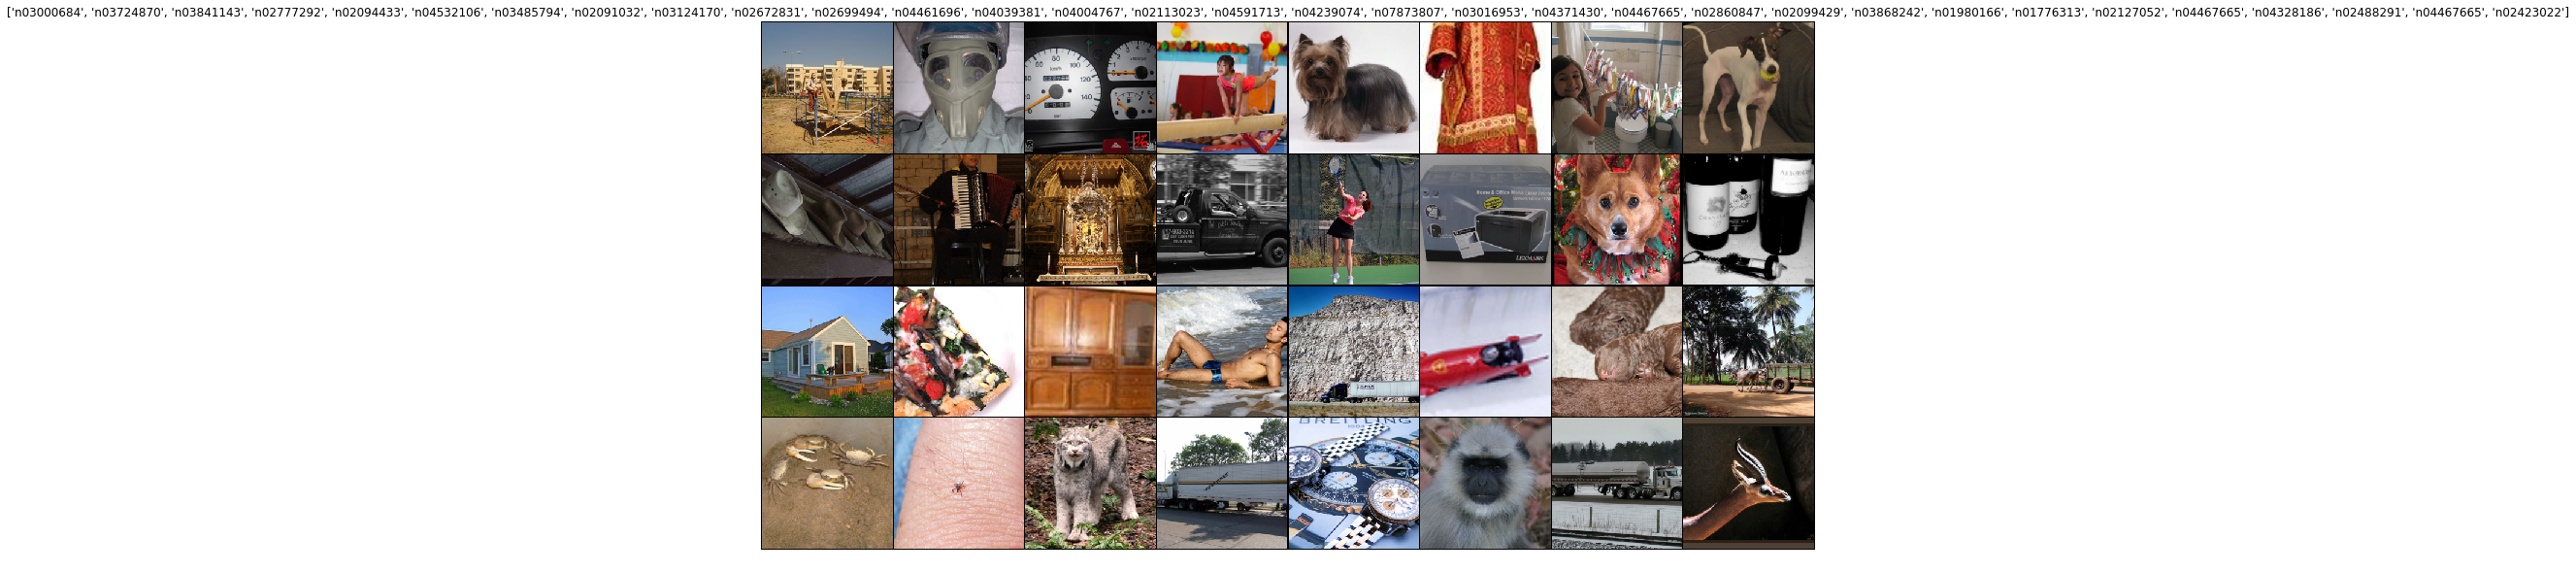

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(30, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])
    
def visualize_model(vgg, num_images=6):
    with torch.no_grad():
        vgg.eval()
        images_so_far = 0

        for i, data in enumerate(dataloaders[TEST]):
            inputs, labels = data
            size = inputs.size()[0]

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]

            print("Ground truth:")
            show_databatch(inputs.data.cpu(), labels.data.cpu())
            print("Prediction:")
            show_databatch(inputs.data.cpu(), predicted_labels)

            del inputs, labels, outputs, preds, predicted_labels
            torch.cuda.empty_cache()

            images_so_far += size
            if images_so_far >= num_images:
                break

    vgg.train() # Revert model back to original training state


# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [5]:
use_gpu = torch.cuda.is_available()

def train_model(vgg, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[TEST])
    
    for epoch in range(num_epochs):
        since_batch = time.time()
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            
            if i % 1 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                loss_train += loss.data.item()
                #print(preds, labels.data)
                acc_train += torch.sum(preds == labels.data).item()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        elapsed_time = time.time() - since_batch
        print("\rEpoch completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train / float(dataset_sizes[TRAIN])
        avg_acc = acc_train / float(dataset_sizes[TRAIN])
        
        with torch.no_grad():
            vgg.train(False)
            vgg.eval()
            #criterion.eval()

            for i, data in enumerate(dataloaders[TEST]):
                if i % 1 == 0:
                    print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

                inputs, labels = data

                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()

                optimizer.zero_grad()

                outputs = vgg(inputs)

                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                loss_val += loss.data.item()
                acc_val += torch.sum(preds == labels.data).item()

                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()

        avg_loss_val = loss_val / dataset_sizes[TEST]
        avg_acc_val = acc_val / dataset_sizes[TEST]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [6]:
vgg16 = models.vgg16_bn(pretrained=True).cuda()

if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

resume_training = True

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('./models/VGG16_imagenet.pt'))
    print("Loaded!")

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loading pretrained model..
Loaded!


In [7]:
vgg16 = train_model(vgg16, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)
torch.save(vgg16.state_dict(), './models/VGG16_imagenet.pt')

Epoch 0/2
----------
Epoch completed in 2m 31s

Validation batch 312/313
Epoch 0 result: 
Avg loss (train): 0.0051
Avg acc (train): 0.9537
Avg loss (val): 0.0481
Avg acc (val): 0.6714
----------

Epoch 1/2
----------
Epoch completed in 2m 27s

Validation batch 312/313
Epoch 1 result: 
Avg loss (train): 0.0032
Avg acc (train): 0.9706
Avg loss (val): 0.0501
Avg acc (val): 0.6691
----------


Training completed in 6m 20s
Best acc: 0.6714


Ground truth:


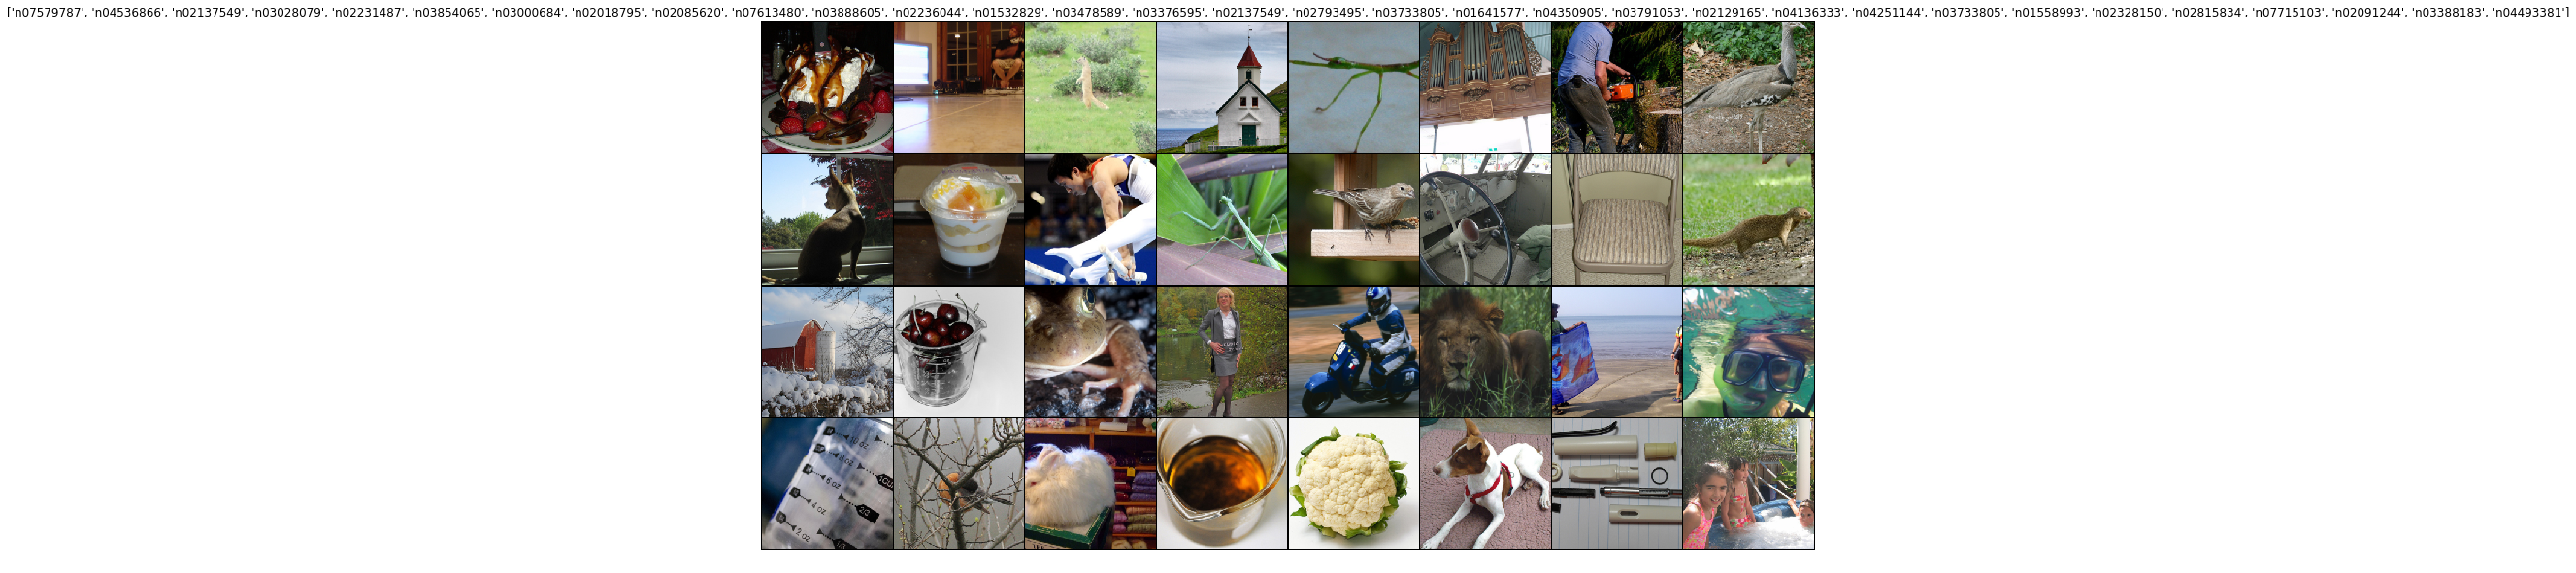

Prediction:


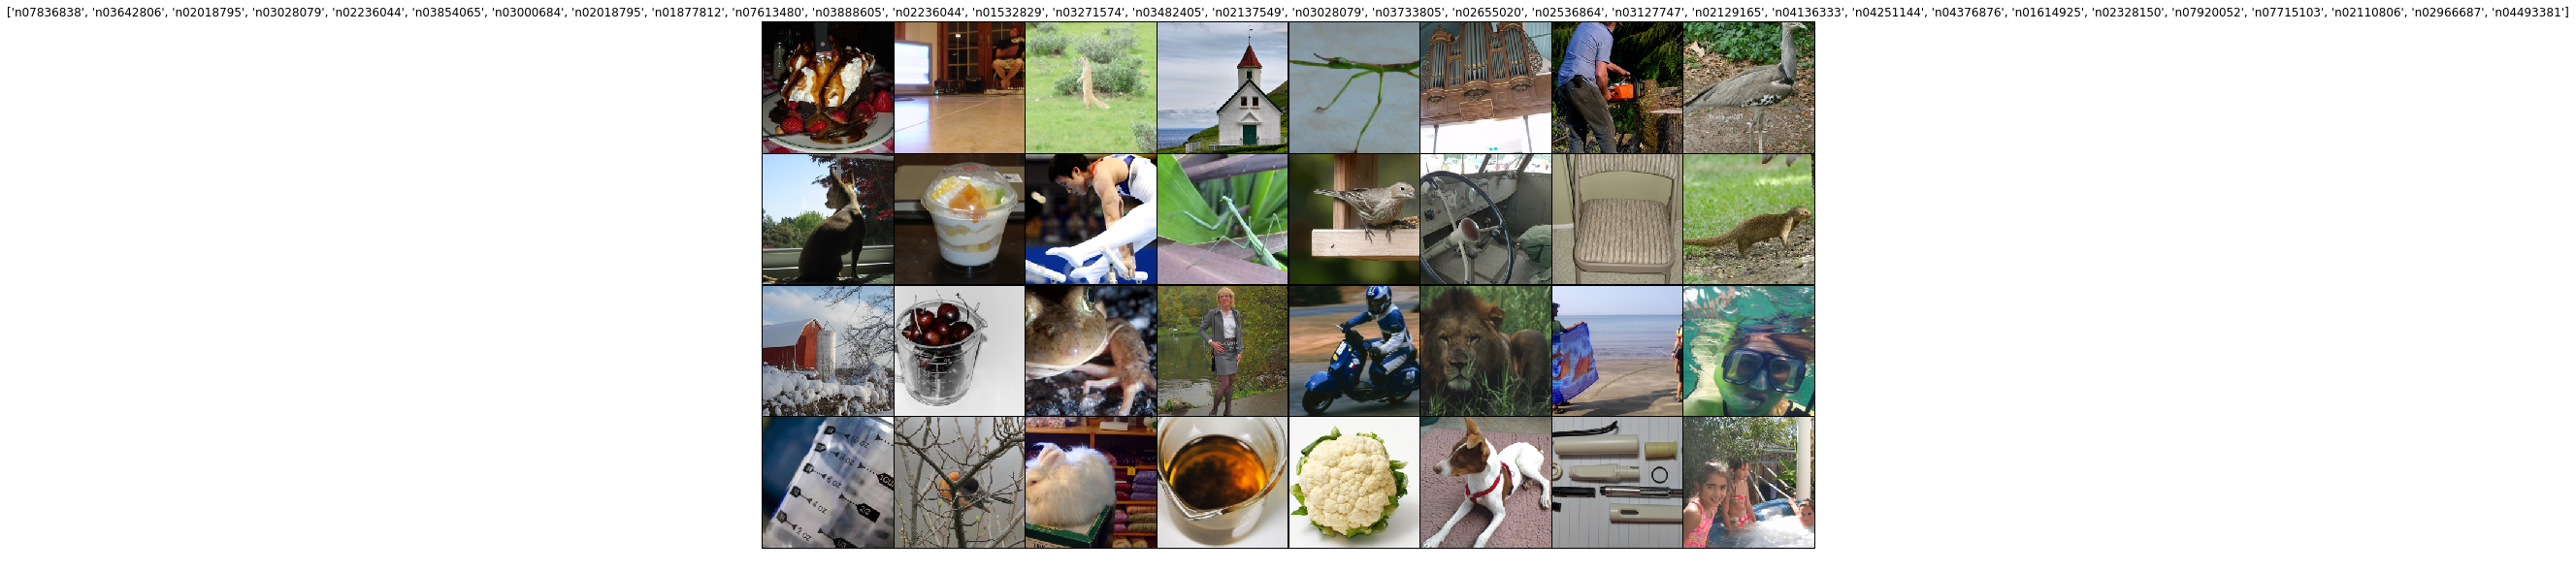

In [8]:
visualize_model(vgg16, 8)

In [16]:
from torch.utils.data import TensorDataset

In [ ]:
TensorDataset()

### G

In [9]:
train_input = []
train_target = []

with torch.no_grad():
    for image in image_datasets[TRAIN]:
        train_input.append(image[0])
        train_target.append(image[1])
        
    #del image_datasets[TRAIN]
    train_input = torch.cat(train_input, 1)
    train_target = torch.Tensor(train_target)

In [10]:
test_input = []
test_target = []

with torch.no_grad():
    for image in image_datasets[TEST]:
        test_input.append(image[0])
        test_target.append(image[1])
    
    #del image_datasets[TEST]
test_input = torch.cat(test_input, 1)
test_target = torch.Tensor(test_target)

In [11]:
if use_gpu:
    train_input = train_input.cuda()
    #train_target = train_target.cuda()
    test_input = test_input.cuda()
    #test_target = test_target.cuda()

RuntimeError: CUDA error: out of memory

In [18]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [20]:
g_train_dataset, g_test_dataset = generate_dataset_g(vgg16, (train_input, train_target),
                   (test_input, test_target), 
                   [vgg16.features[40]], 
                   ['conv512'], split=0.7, full=True)

RuntimeError: Expected a Tensor of type torch.cuda.FloatTensor but found a type torch.FloatTensor for sequence element 1 in sequence argument at position #1 'tensors'